In [84]:
from dataclasses import dataclass
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from fuzzy_layer import FuzzyLayer

In [85]:
batch_size = 256
learning_rate = 2e-3
weight_decay = 1e-2
num_epochs = 50
latent_dim = 20
beta = 1
gamma = 1 
fuzzy_labels = 12 #10 цифр + 2 класса на цифры с кругляшками и без
unknown_classes_ratio = 0.0 # доля неизвестных классов 
is_fuzzy_loss_active = True

prefix = "vae"
if is_fuzzy_loss_active:
    prefix = f"fuzzy_cvae_with_unknown_ratio_{unknown_classes_ratio}"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if is_fuzzy_loss_active:
    gamma = 1
else:
    gamma = 0

In [86]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

In [87]:
def get_target_and_mask(target_label, unknown_ratio):
    """
    Возвращает вектор целевого значения и маску в виде сдвоенного тензора

    Args:
        target_label (int): Метка класса
        unknown_ratio (float): Доля примеров в датасете, чья разметка будет игнорироваться при обучении
    
    Returns:
        tensor (2, 12)
    """
    t = F.one_hot(torch.LongTensor([target_label]), fuzzy_labels)
    if (target_label == 0) or (target_label == 6) or (target_label == 8) or (target_label == 9):
        t[0][fuzzy_labels - 2] = 1
    else:
        t[0][fuzzy_labels - 1] = 1
    m = torch.ones((1, fuzzy_labels)) if torch.rand(1) > unknown_ratio else torch.zeros((1, fuzzy_labels))
    
    return torch.cat((t, m), 0).to(device) 

In [88]:
# загружаем обучающую выборку
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x,unknown_classes_ratio))
)

In [89]:
# загружаем тестовую выборку
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x, 0))
)
len(test_data)

10000

In [90]:
# Создаем итераторы датасетов
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

In [91]:
class Encoder(nn.Module):
    """
    Компонент энкодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(8, 16, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(16, 32, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.SiLU(),  
            nn.Flatten(),
            nn.Linear(9216, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(),  
            nn.Linear(625, 2 * latent_dim), # mean + variance.
        )
        self.softplus = nn.Softplus()
         
    def forward(self, x, eps: float = 1e-8):
        """
        Выход энкодера для чистого VAE.
        
        Args:
            x (torch.Tensor): Входной вектор.
            eps (float): Небольшая поправка к скейлу для лучшей сходимости и устойчивости.
        
        Returns:
            mu, logvar, z, dist
        """

        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        dist = torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        z = dist.rsample()

        return mu, logvar, z

In [92]:
class Decoder(nn.Module):
    """
    Компонент декодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
                
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(), 
            nn.Linear(625, 9216),
            nn.BatchNorm1d(9216),
            nn.SiLU(), 
            nn.Unflatten(1,(64, 12, 12)),
            nn.ConvTranspose2d(64, 32, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(32, 16, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(16, 8, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(8, 1, 5),
            nn.Sigmoid() 
        )
         
    def forward(self, z):
        """
        Декодирует латентный вектор в исходное представление
        
        Args:
            z (torch.Tensor): Латентный вектор.
        
        Returns:
            x
        """

        x = self.decoder(z)
        
        return x

In [93]:
class CVAE(nn.Module):
    """
    Conditional Variational Autoencoder (C-VAE) 
    
    Args:
        latent_dim (int): Размер латентного вектора.
        labels_count (int): Количество выходов классификатора
    """
    def __init__(self, latent_dim, labels_count):
        super(CVAE, self).__init__()

        self.encoder = Encoder(latent_dim)        
        self.decoder = Decoder(latent_dim)

        self.fuzzy = nn.Sequential(
            FuzzyLayer.fromdimentions(latent_dim, labels_count, trainable=True)
        )
        
    def forward(self, x):
        """
        Возвращает компоненты внутренних слоев CVAE, результаты реконструкции и классификации
        
        Args:
            x (torch.Tensor): Входной вектор.
        
        Returns:
            mu, x_recon, labels
        """

        mu, _,  _, = self.encoder(x)
        x_recon = self.decoder(mu)
        labels = self.fuzzy(mu)

        return mu, x_recon, labels
    
    def half_pass(self, x):
        """
        Возвращает результаты работы энкодера и классификатора
        """
        mu, logvar, z = self.encoder(x)
        labels = self.fuzzy(mu)

        return mu, logvar, z, labels
    
    def decoder_pass(self, x):
        return self.decoder(x)


In [94]:
def compute_loss(x, recon_x, mu, logvar, z, target_labels, predicted_labels):
    
    loss_recon = F.binary_cross_entropy(recon_x, x + 0.5, reduction='none').sum(-1).mean()
    
    tsquare = torch.square(mu)
    tlogvar = torch.exp(logvar)
    kl_loss = -0.5 * (1 + logvar - tsquare - tlogvar)
    loss_kl = kl_loss.sum(-1).mean()
            
    target_firings = target_labels[:,0,:]
    mask = target_labels[:,1,:]
    loss_fuzzy = (mask * torch.square(target_firings - predicted_labels)).sum(-1).mean()

    loss = loss_recon + beta * loss_kl + gamma * loss_fuzzy

    

    return loss, loss_recon, loss_kl, loss_fuzzy
    

In [95]:
model = CVAE(latent_dim=latent_dim, labels_count=fuzzy_labels).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 11,729,083


CVAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
      (1): SiLU()
      (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
      (3): SiLU()
      (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (5): SiLU()
      (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): SiLU()
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=9216, out_features=625, bias=True)
      (11): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): SiLU()
      (13): Linear(in_features=625, out_features=40, bias=True)
    )
    (softplus): Softplus(beta=1, threshold=20)
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=20, out_features=625, bias=True)
      (1): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [96]:
# import torchviz
# import os
# os.environ["PATH"] += os.pathsep + 'F:/Users/Yuri/Downloads/windows_10_msbuild_Release_graphviz-7.0.4-win32/Graphviz/bin'


# x = torch.randn(2, 1, 28, 28).to(device)
# torchviz.make_dot(model(x), params=dict(model.named_parameters()))

In [97]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [98]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    model.train()  
    
    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        
        optimizer.zero_grad()  
        
        mu, logcar, z, labels = model.half_pass(data)  
        recon_x = model.decoder_pass(z)
        loss, loss_recon, loss_kl, loss_fuzzy = compute_loss(data, recon_x, mu, logcar, z, target, labels)
        
        loss.backward()
        
        if n_upd % 100 == 0:
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
        
            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {loss_recon.item():.4f}, KL: {loss_kl.item():.4f} Fuzzy: {loss_fuzzy.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/BCE', loss_recon.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', loss_kl.item(), global_step)
                writer.add_scalar('Fuzzy/Train/Loss', loss_fuzzy.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)
            
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()  
        
    return prev_updates + len(dataloader)

In [99]:
def test(model, dataloader, cur_step, writer=None):
    model.eval() 
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0
    test_fuzzy_loss = 0
    test_accuracy = 0
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            mu, logcar, z, labels = model.half_pass(data)  
            recon_x = model.decoder_pass(z)
            loss, loss_recon, loss_kl, loss_fuzzy = compute_loss(data, recon_x, mu, logcar, z,  target, labels)
            
            test_loss += loss.item()
            test_recon_loss += loss_recon.item()
            test_kl_loss += loss_kl.item()
            test_fuzzy_loss += loss_fuzzy.item()
            pred_target = np.argmax(labels[:,0:(fuzzy_labels-2)].cpu().numpy(), axis=1)
            target_labels =  np.argmax(target[:,0,0:(fuzzy_labels-2)].cpu().numpy(), axis=1)
            test_accuracy += np.sum(target_labels==pred_target) / len(pred_target)

    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    test_fuzzy_loss /= len(dataloader)
    test_accuracy /= len(dataloader)

    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f} Fuzzy: {test_fuzzy_loss:.4f} Accuracy {test_accuracy:.4f})')
    
    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/BCE', loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', loss_kl.item(), global_step=cur_step)
        writer.add_scalar('Fuzzy/Test/Loss', loss_fuzzy.item(), global_step=cur_step)
        writer.add_scalar('Fuzzy/Test/Accuracy', test_accuracy, global_step=cur_step)
        
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decoder_pass(z)
        writer.add_images('Test/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)

In [100]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)

Epoch 1/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 0 (N samples: 0), Loss: 24.8147 (Recon: 20.9510, KL: 1.9146 Fuzzy: 1.9491) Grad: 19.1834
Step 100 (N samples: 25,600), Loss: 9.1907 (Recon: 7.0507, KL: 0.5528 Fuzzy: 1.5872) Grad: 12.9502
Step 200 (N samples: 51,200), Loss: 8.1241 (Recon: 6.7160, KL: 0.7390 Fuzzy: 0.6691) Grad: 5.9215


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 8.0359 (BCE: 6.6330, KLD: 0.8467 Fuzzy: 0.5562 Accuracy 0.9182)
Epoch 2/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 300 (N samples: 76,800), Loss: 7.8451 (Recon: 6.5667, KL: 0.8465 Fuzzy: 0.4319) Grad: 8.5551
Step 400 (N samples: 102,400), Loss: 7.5177 (Recon: 6.4055, KL: 0.8102 Fuzzy: 0.3020) Grad: 4.5354


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4570 (BCE: 6.2909, KLD: 0.9107 Fuzzy: 0.2553 Accuracy 0.9698)
Epoch 3/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 500 (N samples: 128,000), Loss: 7.4350 (Recon: 6.3101, KL: 0.8641 Fuzzy: 0.2608) Grad: 4.5136
Step 600 (N samples: 153,600), Loss: 7.4229 (Recon: 6.2820, KL: 0.8899 Fuzzy: 0.2510) Grad: 6.3090
Step 700 (N samples: 179,200), Loss: 7.4447 (Recon: 6.3096, KL: 0.9215 Fuzzy: 0.2136) Grad: 5.7117


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3405 (BCE: 6.1525, KLD: 0.9917 Fuzzy: 0.1964 Accuracy 0.9774)
Epoch 4/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 800 (N samples: 204,800), Loss: 7.1753 (Recon: 5.9018, KL: 1.0629 Fuzzy: 0.2106) Grad: 3.6760
Step 900 (N samples: 230,400), Loss: 7.3947 (Recon: 6.1674, KL: 1.0871 Fuzzy: 0.1402) Grad: 4.0548


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1826 (BCE: 5.9883, KLD: 1.0608 Fuzzy: 0.1335 Accuracy 0.9850)
Epoch 5/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,000 (N samples: 256,000), Loss: 7.0870 (Recon: 5.8424, KL: 1.1083 Fuzzy: 0.1363) Grad: 4.0253
Step 1,100 (N samples: 281,600), Loss: 7.2299 (Recon: 5.9673, KL: 1.1069 Fuzzy: 0.1557) Grad: 4.5537


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0996 (BCE: 5.8034, KLD: 1.1734 Fuzzy: 0.1228 Accuracy 0.9864)
Epoch 6/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,200 (N samples: 307,200), Loss: 7.1917 (Recon: 5.8923, KL: 1.1509 Fuzzy: 0.1485) Grad: 3.4458
Step 1,300 (N samples: 332,800), Loss: 7.0861 (Recon: 5.8508, KL: 1.1127 Fuzzy: 0.1225) Grad: 2.0450
Step 1,400 (N samples: 358,400), Loss: 7.0016 (Recon: 5.7349, KL: 1.1601 Fuzzy: 0.1066) Grad: 5.7325


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1005 (BCE: 5.8236, KLD: 1.1618 Fuzzy: 0.1151 Accuracy 0.9865)
Epoch 7/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,500 (N samples: 384,000), Loss: 7.2956 (Recon: 6.0105, KL: 1.1657 Fuzzy: 0.1195) Grad: 3.4947
Step 1,600 (N samples: 409,600), Loss: 7.2952 (Recon: 6.0228, KL: 1.1587 Fuzzy: 0.1137) Grad: 3.6680


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0369 (BCE: 5.7632, KLD: 1.1747 Fuzzy: 0.0990 Accuracy 0.9878)
Epoch 8/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,700 (N samples: 435,200), Loss: 7.1345 (Recon: 5.8653, KL: 1.1839 Fuzzy: 0.0853) Grad: 2.4389
Step 1,800 (N samples: 460,800), Loss: 7.0255 (Recon: 5.7230, KL: 1.2161 Fuzzy: 0.0865) Grad: 1.8635


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0343 (BCE: 5.7408, KLD: 1.1995 Fuzzy: 0.0940 Accuracy 0.9886)
Epoch 9/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,900 (N samples: 486,400), Loss: 6.9666 (Recon: 5.6600, KL: 1.1900 Fuzzy: 0.1167) Grad: 3.3299
Step 2,000 (N samples: 512,000), Loss: 7.0252 (Recon: 5.7764, KL: 1.1815 Fuzzy: 0.0672) Grad: 2.9489
Step 2,100 (N samples: 537,600), Loss: 6.9909 (Recon: 5.7162, KL: 1.1954 Fuzzy: 0.0792) Grad: 2.0310


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0063 (BCE: 5.6805, KLD: 1.2376 Fuzzy: 0.0882 Accuracy 0.9895)
Epoch 10/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,200 (N samples: 563,200), Loss: 6.9545 (Recon: 5.6512, KL: 1.2024 Fuzzy: 0.1009) Grad: 2.4459
Step 2,300 (N samples: 588,800), Loss: 6.8242 (Recon: 5.5231, KL: 1.2416 Fuzzy: 0.0595) Grad: 1.7109


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9975 (BCE: 5.7147, KLD: 1.2071 Fuzzy: 0.0757 Accuracy 0.9916)
Epoch 11/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,400 (N samples: 614,400), Loss: 7.0842 (Recon: 5.7876, KL: 1.2154 Fuzzy: 0.0813) Grad: 3.2295
Step 2,500 (N samples: 640,000), Loss: 6.9617 (Recon: 5.6972, KL: 1.2094 Fuzzy: 0.0551) Grad: 2.0599


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9858 (BCE: 5.6806, KLD: 1.2204 Fuzzy: 0.0848 Accuracy 0.9906)
Epoch 12/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,600 (N samples: 665,600), Loss: 7.0437 (Recon: 5.7714, KL: 1.2064 Fuzzy: 0.0659) Grad: 2.7298
Step 2,700 (N samples: 691,200), Loss: 6.9232 (Recon: 5.6014, KL: 1.2366 Fuzzy: 0.0852) Grad: 2.9101
Step 2,800 (N samples: 716,800), Loss: 6.9556 (Recon: 5.6919, KL: 1.1833 Fuzzy: 0.0804) Grad: 3.0407


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9830 (BCE: 5.6909, KLD: 1.2166 Fuzzy: 0.0755 Accuracy 0.9911)
Epoch 13/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,900 (N samples: 742,400), Loss: 6.8764 (Recon: 5.5476, KL: 1.2712 Fuzzy: 0.0576) Grad: 1.9168
Step 3,000 (N samples: 768,000), Loss: 6.9700 (Recon: 5.6581, KL: 1.2536 Fuzzy: 0.0584) Grad: 2.9030


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9684 (BCE: 5.6622, KLD: 1.2416 Fuzzy: 0.0646 Accuracy 0.9905)
Epoch 14/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,100 (N samples: 793,600), Loss: 7.1115 (Recon: 5.7809, KL: 1.2362 Fuzzy: 0.0945) Grad: 3.7605
Step 3,200 (N samples: 819,200), Loss: 6.8349 (Recon: 5.5430, KL: 1.2338 Fuzzy: 0.0581) Grad: 2.5824


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9558 (BCE: 5.5805, KLD: 1.3099 Fuzzy: 0.0654 Accuracy 0.9912)
Epoch 15/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,300 (N samples: 844,800), Loss: 7.0503 (Recon: 5.7594, KL: 1.2378 Fuzzy: 0.0531) Grad: 1.9990
Step 3,400 (N samples: 870,400), Loss: 6.9716 (Recon: 5.6379, KL: 1.2782 Fuzzy: 0.0555) Grad: 2.0583
Step 3,500 (N samples: 896,000), Loss: 7.0114 (Recon: 5.6991, KL: 1.2591 Fuzzy: 0.0532) Grad: 3.0684


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9444 (BCE: 5.6348, KLD: 1.2511 Fuzzy: 0.0585 Accuracy 0.9932)
Epoch 16/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,600 (N samples: 921,600), Loss: 6.9367 (Recon: 5.6458, KL: 1.2388 Fuzzy: 0.0521) Grad: 1.8617
Step 3,700 (N samples: 947,200), Loss: 6.8967 (Recon: 5.5621, KL: 1.2876 Fuzzy: 0.0469) Grad: 2.1108


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9491 (BCE: 5.5981, KLD: 1.2866 Fuzzy: 0.0644 Accuracy 0.9929)
Epoch 17/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,800 (N samples: 972,800), Loss: 6.9790 (Recon: 5.6809, KL: 1.2544 Fuzzy: 0.0437) Grad: 2.0355
Step 3,900 (N samples: 998,400), Loss: 7.0462 (Recon: 5.7598, KL: 1.2263 Fuzzy: 0.0601) Grad: 2.1582


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9478 (BCE: 5.6532, KLD: 1.2334 Fuzzy: 0.0613 Accuracy 0.9930)
Epoch 18/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,000 (N samples: 1,024,000), Loss: 7.0074 (Recon: 5.7152, KL: 1.2377 Fuzzy: 0.0545) Grad: 2.2399
Step 4,100 (N samples: 1,049,600), Loss: 7.0535 (Recon: 5.6832, KL: 1.2990 Fuzzy: 0.0714) Grad: 2.9980
Step 4,200 (N samples: 1,075,200), Loss: 6.8315 (Recon: 5.4716, KL: 1.2941 Fuzzy: 0.0659) Grad: 2.8656


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9457 (BCE: 5.6210, KLD: 1.2716 Fuzzy: 0.0531 Accuracy 0.9928)
Epoch 19/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,300 (N samples: 1,100,800), Loss: 7.0585 (Recon: 5.7626, KL: 1.2480 Fuzzy: 0.0479) Grad: 2.5880
Step 4,400 (N samples: 1,126,400), Loss: 7.1574 (Recon: 5.8425, KL: 1.2592 Fuzzy: 0.0556) Grad: 3.0742


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9662 (BCE: 5.6459, KLD: 1.2595 Fuzzy: 0.0608 Accuracy 0.9930)
Epoch 20/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,500 (N samples: 1,152,000), Loss: 6.9005 (Recon: 5.5522, KL: 1.2867 Fuzzy: 0.0616) Grad: 2.0090
Step 4,600 (N samples: 1,177,600), Loss: 6.9437 (Recon: 5.6293, KL: 1.2722 Fuzzy: 0.0422) Grad: 2.3437


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9637 (BCE: 5.6114, KLD: 1.2848 Fuzzy: 0.0675 Accuracy 0.9925)
Epoch 21/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,700 (N samples: 1,203,200), Loss: 6.9546 (Recon: 5.6200, KL: 1.2710 Fuzzy: 0.0636) Grad: 2.7800
Step 4,800 (N samples: 1,228,800), Loss: 6.9486 (Recon: 5.6402, KL: 1.2664 Fuzzy: 0.0420) Grad: 1.7754
Step 4,900 (N samples: 1,254,400), Loss: 7.0003 (Recon: 5.6420, KL: 1.3025 Fuzzy: 0.0559) Grad: 2.6503


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9646 (BCE: 5.6541, KLD: 1.2504 Fuzzy: 0.0601 Accuracy 0.9934)
Epoch 22/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,000 (N samples: 1,280,000), Loss: 6.8951 (Recon: 5.5731, KL: 1.2554 Fuzzy: 0.0666) Grad: 3.6443
Step 5,100 (N samples: 1,305,600), Loss: 6.7519 (Recon: 5.4673, KL: 1.2307 Fuzzy: 0.0539) Grad: 2.8187


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9212 (BCE: 5.6145, KLD: 1.2520 Fuzzy: 0.0548 Accuracy 0.9926)
Epoch 23/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,200 (N samples: 1,331,200), Loss: 6.7139 (Recon: 5.3950, KL: 1.2761 Fuzzy: 0.0428) Grad: 1.9501
Step 5,300 (N samples: 1,356,800), Loss: 7.0882 (Recon: 5.7121, KL: 1.3219 Fuzzy: 0.0542) Grad: 2.2937
Step 5,400 (N samples: 1,382,400), Loss: 7.0295 (Recon: 5.7910, KL: 1.1980 Fuzzy: 0.0405) Grad: 2.1642


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9369 (BCE: 5.6549, KLD: 1.2236 Fuzzy: 0.0584 Accuracy 0.9921)
Epoch 24/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,500 (N samples: 1,408,000), Loss: 6.9299 (Recon: 5.5972, KL: 1.2906 Fuzzy: 0.0421) Grad: 2.3815
Step 5,600 (N samples: 1,433,600), Loss: 6.7710 (Recon: 5.4829, KL: 1.2546 Fuzzy: 0.0335) Grad: 1.7394


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9342 (BCE: 5.6312, KLD: 1.2572 Fuzzy: 0.0458 Accuracy 0.9938)
Epoch 25/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,700 (N samples: 1,459,200), Loss: 7.0333 (Recon: 5.7166, KL: 1.2717 Fuzzy: 0.0450) Grad: 2.9029
Step 5,800 (N samples: 1,484,800), Loss: 6.9761 (Recon: 5.6091, KL: 1.3090 Fuzzy: 0.0580) Grad: 2.6812


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9099 (BCE: 5.6197, KLD: 1.2452 Fuzzy: 0.0450 Accuracy 0.9946)
Epoch 26/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,900 (N samples: 1,510,400), Loss: 6.9247 (Recon: 5.5997, KL: 1.2821 Fuzzy: 0.0429) Grad: 3.1112
Step 6,000 (N samples: 1,536,000), Loss: 6.8994 (Recon: 5.5867, KL: 1.2670 Fuzzy: 0.0457) Grad: 2.3914
Step 6,100 (N samples: 1,561,600), Loss: 6.8602 (Recon: 5.5584, KL: 1.2560 Fuzzy: 0.0458) Grad: 2.3893


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9269 (BCE: 5.6189, KLD: 1.2529 Fuzzy: 0.0551 Accuracy 0.9934)
Epoch 27/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,200 (N samples: 1,587,200), Loss: 6.8982 (Recon: 5.5734, KL: 1.2848 Fuzzy: 0.0401) Grad: 2.7257
Step 6,300 (N samples: 1,612,800), Loss: 6.8872 (Recon: 5.5492, KL: 1.2923 Fuzzy: 0.0456) Grad: 3.4486


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9379 (BCE: 5.6439, KLD: 1.2445 Fuzzy: 0.0495 Accuracy 0.9937)
Epoch 28/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,400 (N samples: 1,638,400), Loss: 6.9722 (Recon: 5.6793, KL: 1.2519 Fuzzy: 0.0410) Grad: 2.2785
Step 6,500 (N samples: 1,664,000), Loss: 7.0726 (Recon: 5.7269, KL: 1.3059 Fuzzy: 0.0397) Grad: 2.5520


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9256 (BCE: 5.5715, KLD: 1.2835 Fuzzy: 0.0706 Accuracy 0.9936)
Epoch 29/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,600 (N samples: 1,689,600), Loss: 6.9825 (Recon: 5.6813, KL: 1.2657 Fuzzy: 0.0356) Grad: 1.8897
Step 6,700 (N samples: 1,715,200), Loss: 6.9265 (Recon: 5.6334, KL: 1.2540 Fuzzy: 0.0390) Grad: 2.1693
Step 6,800 (N samples: 1,740,800), Loss: 7.0747 (Recon: 5.7331, KL: 1.3038 Fuzzy: 0.0379) Grad: 1.9083


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8960 (BCE: 5.6101, KLD: 1.2381 Fuzzy: 0.0478 Accuracy 0.9931)
Epoch 30/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,900 (N samples: 1,766,400), Loss: 6.8159 (Recon: 5.4808, KL: 1.2734 Fuzzy: 0.0617) Grad: 3.5890
Step 7,000 (N samples: 1,792,000), Loss: 6.9434 (Recon: 5.5994, KL: 1.2974 Fuzzy: 0.0466) Grad: 2.5247


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8985 (BCE: 5.5858, KLD: 1.2671 Fuzzy: 0.0455 Accuracy 0.9934)
Epoch 31/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,100 (N samples: 1,817,600), Loss: 6.9464 (Recon: 5.6449, KL: 1.2767 Fuzzy: 0.0247) Grad: 2.1206
Step 7,200 (N samples: 1,843,200), Loss: 6.9496 (Recon: 5.6079, KL: 1.3061 Fuzzy: 0.0355) Grad: 2.2136


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8881 (BCE: 5.6339, KLD: 1.2081 Fuzzy: 0.0461 Accuracy 0.9934)
Epoch 32/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,300 (N samples: 1,868,800), Loss: 6.8592 (Recon: 5.5258, KL: 1.2972 Fuzzy: 0.0362) Grad: 2.2084
Step 7,400 (N samples: 1,894,400), Loss: 6.8189 (Recon: 5.4866, KL: 1.2886 Fuzzy: 0.0437) Grad: 3.1660
Step 7,500 (N samples: 1,920,000), Loss: 6.9017 (Recon: 5.5972, KL: 1.2769 Fuzzy: 0.0276) Grad: 1.8652


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9109 (BCE: 5.6011, KLD: 1.2581 Fuzzy: 0.0518 Accuracy 0.9934)
Epoch 33/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,600 (N samples: 1,945,600), Loss: 6.9972 (Recon: 5.6926, KL: 1.2744 Fuzzy: 0.0303) Grad: 1.5508
Step 7,700 (N samples: 1,971,200), Loss: 6.9435 (Recon: 5.5993, KL: 1.2903 Fuzzy: 0.0538) Grad: 2.1354


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8974 (BCE: 5.5919, KLD: 1.2580 Fuzzy: 0.0476 Accuracy 0.9930)
Epoch 34/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,800 (N samples: 1,996,800), Loss: 6.8998 (Recon: 5.6181, KL: 1.2442 Fuzzy: 0.0375) Grad: 2.3944
Step 7,900 (N samples: 2,022,400), Loss: 6.9675 (Recon: 5.6434, KL: 1.2907 Fuzzy: 0.0334) Grad: 2.2421


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8978 (BCE: 5.5677, KLD: 1.2876 Fuzzy: 0.0425 Accuracy 0.9930)
Epoch 35/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,000 (N samples: 2,048,000), Loss: 6.7156 (Recon: 5.4325, KL: 1.2558 Fuzzy: 0.0273) Grad: 2.0031
Step 8,100 (N samples: 2,073,600), Loss: 6.7149 (Recon: 5.3813, KL: 1.2971 Fuzzy: 0.0365) Grad: 2.3275
Step 8,200 (N samples: 2,099,200), Loss: 6.9301 (Recon: 5.6135, KL: 1.2805 Fuzzy: 0.0361) Grad: 2.0925


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9053 (BCE: 5.5712, KLD: 1.2775 Fuzzy: 0.0566 Accuracy 0.9937)
Epoch 36/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,300 (N samples: 2,124,800), Loss: 6.7645 (Recon: 5.4454, KL: 1.2939 Fuzzy: 0.0252) Grad: 1.9782
Step 8,400 (N samples: 2,150,400), Loss: 7.1288 (Recon: 5.7609, KL: 1.3244 Fuzzy: 0.0436) Grad: 2.3819


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9147 (BCE: 5.5591, KLD: 1.3091 Fuzzy: 0.0465 Accuracy 0.9929)
Epoch 37/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,500 (N samples: 2,176,000), Loss: 6.9312 (Recon: 5.6264, KL: 1.2739 Fuzzy: 0.0309) Grad: 1.7348
Step 8,600 (N samples: 2,201,600), Loss: 6.9913 (Recon: 5.6738, KL: 1.2859 Fuzzy: 0.0316) Grad: 1.9559


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9326 (BCE: 5.5523, KLD: 1.3171 Fuzzy: 0.0632 Accuracy 0.9933)
Epoch 38/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,700 (N samples: 2,227,200), Loss: 6.8831 (Recon: 5.5584, KL: 1.2960 Fuzzy: 0.0287) Grad: 2.1062
Step 8,800 (N samples: 2,252,800), Loss: 6.8102 (Recon: 5.4751, KL: 1.3091 Fuzzy: 0.0260) Grad: 2.0977
Step 8,900 (N samples: 2,278,400), Loss: 6.8757 (Recon: 5.5601, KL: 1.2909 Fuzzy: 0.0246) Grad: 1.7155


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8952 (BCE: 5.5915, KLD: 1.2571 Fuzzy: 0.0466 Accuracy 0.9938)
Epoch 39/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,000 (N samples: 2,304,000), Loss: 6.8274 (Recon: 5.5184, KL: 1.2770 Fuzzy: 0.0320) Grad: 1.7094
Step 9,100 (N samples: 2,329,600), Loss: 7.0634 (Recon: 5.6694, KL: 1.3020 Fuzzy: 0.0919) Grad: 5.0224


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8701 (BCE: 5.5743, KLD: 1.2588 Fuzzy: 0.0370 Accuracy 0.9933)
Epoch 40/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,200 (N samples: 2,355,200), Loss: 6.9893 (Recon: 5.6416, KL: 1.3038 Fuzzy: 0.0439) Grad: 2.4861
Step 9,300 (N samples: 2,380,800), Loss: 7.0494 (Recon: 5.7581, KL: 1.2552 Fuzzy: 0.0361) Grad: 2.6144


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8934 (BCE: 5.5764, KLD: 1.2730 Fuzzy: 0.0440 Accuracy 0.9934)
Epoch 41/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,400 (N samples: 2,406,400), Loss: 6.9225 (Recon: 5.6214, KL: 1.2708 Fuzzy: 0.0303) Grad: 2.2131
Step 9,500 (N samples: 2,432,000), Loss: 7.1964 (Recon: 5.8859, KL: 1.2799 Fuzzy: 0.0307) Grad: 2.1692
Step 9,600 (N samples: 2,457,600), Loss: 6.9605 (Recon: 5.6574, KL: 1.2828 Fuzzy: 0.0203) Grad: 1.9904


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9002 (BCE: 5.5479, KLD: 1.3092 Fuzzy: 0.0431 Accuracy 0.9931)
Epoch 42/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,700 (N samples: 2,483,200), Loss: 6.8018 (Recon: 5.4120, KL: 1.3171 Fuzzy: 0.0727) Grad: 3.6655
Step 9,800 (N samples: 2,508,800), Loss: 6.9075 (Recon: 5.5377, KL: 1.3250 Fuzzy: 0.0448) Grad: 3.2861


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8950 (BCE: 5.5491, KLD: 1.2889 Fuzzy: 0.0570 Accuracy 0.9934)
Epoch 43/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,900 (N samples: 2,534,400), Loss: 6.9408 (Recon: 5.5833, KL: 1.3130 Fuzzy: 0.0445) Grad: 2.5424
Step 10,000 (N samples: 2,560,000), Loss: 6.9098 (Recon: 5.5936, KL: 1.2905 Fuzzy: 0.0257) Grad: 1.8665
Step 10,100 (N samples: 2,585,600), Loss: 6.9011 (Recon: 5.5801, KL: 1.2912 Fuzzy: 0.0297) Grad: 2.4324


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8860 (BCE: 5.5903, KLD: 1.2509 Fuzzy: 0.0448 Accuracy 0.9933)
Epoch 44/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,200 (N samples: 2,611,200), Loss: 6.8582 (Recon: 5.5063, KL: 1.3227 Fuzzy: 0.0293) Grad: 1.9867
Step 10,300 (N samples: 2,636,800), Loss: 6.9738 (Recon: 5.6601, KL: 1.2756 Fuzzy: 0.0382) Grad: 2.8265


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8689 (BCE: 5.5353, KLD: 1.2906 Fuzzy: 0.0430 Accuracy 0.9935)
Epoch 45/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,400 (N samples: 2,662,400), Loss: 6.7584 (Recon: 5.4256, KL: 1.3142 Fuzzy: 0.0187) Grad: 1.6976
Step 10,500 (N samples: 2,688,000), Loss: 6.9207 (Recon: 5.5700, KL: 1.3200 Fuzzy: 0.0308) Grad: 2.1505


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8944 (BCE: 5.5085, KLD: 1.3352 Fuzzy: 0.0506 Accuracy 0.9938)
Epoch 46/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,600 (N samples: 2,713,600), Loss: 6.8120 (Recon: 5.4621, KL: 1.3184 Fuzzy: 0.0314) Grad: 2.0759
Step 10,700 (N samples: 2,739,200), Loss: 6.8384 (Recon: 5.5105, KL: 1.2972 Fuzzy: 0.0307) Grad: 2.1923
Step 10,800 (N samples: 2,764,800), Loss: 6.8996 (Recon: 5.5560, KL: 1.3042 Fuzzy: 0.0395) Grad: 2.6062


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8839 (BCE: 5.5445, KLD: 1.2999 Fuzzy: 0.0395 Accuracy 0.9933)
Epoch 47/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,900 (N samples: 2,790,400), Loss: 7.0215 (Recon: 5.7165, KL: 1.2794 Fuzzy: 0.0256) Grad: 2.3443
Step 11,000 (N samples: 2,816,000), Loss: 6.9951 (Recon: 5.6831, KL: 1.2948 Fuzzy: 0.0172) Grad: 1.4125


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8889 (BCE: 5.6146, KLD: 1.2363 Fuzzy: 0.0380 Accuracy 0.9933)
Epoch 48/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 11,100 (N samples: 2,841,600), Loss: 6.9087 (Recon: 5.5686, KL: 1.3143 Fuzzy: 0.0258) Grad: 2.0853
Step 11,200 (N samples: 2,867,200), Loss: 7.0058 (Recon: 5.6853, KL: 1.2978 Fuzzy: 0.0227) Grad: 1.5084


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8741 (BCE: 5.5446, KLD: 1.2843 Fuzzy: 0.0452 Accuracy 0.9934)
Epoch 49/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 11,300 (N samples: 2,892,800), Loss: 6.9125 (Recon: 5.6160, KL: 1.2756 Fuzzy: 0.0209) Grad: 1.9594
Step 11,400 (N samples: 2,918,400), Loss: 6.8597 (Recon: 5.5282, KL: 1.3064 Fuzzy: 0.0251) Grad: 1.7339
Step 11,500 (N samples: 2,944,000), Loss: 6.9179 (Recon: 5.5960, KL: 1.2951 Fuzzy: 0.0268) Grad: 1.6125


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8835 (BCE: 5.5500, KLD: 1.2796 Fuzzy: 0.0540 Accuracy 0.9930)
Epoch 50/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 11,600 (N samples: 2,969,600), Loss: 6.7837 (Recon: 5.4233, KL: 1.3379 Fuzzy: 0.0225) Grad: 1.9857
Step 11,700 (N samples: 2,995,200), Loss: 6.7196 (Recon: 5.4135, KL: 1.2774 Fuzzy: 0.0286) Grad: 1.6182


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.8794 (BCE: 5.5629, KLD: 1.2757 Fuzzy: 0.0407 Accuracy 0.9933)


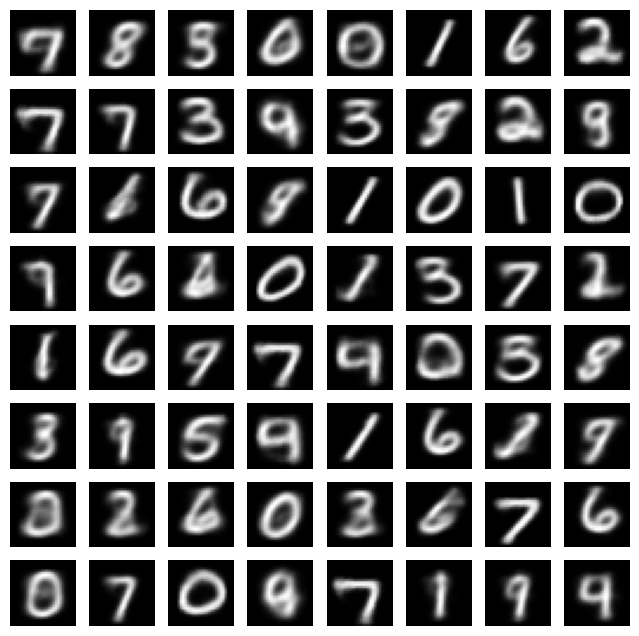

In [101]:
z = torch.randn(64, latent_dim).to(device)
samples = model.decoder_pass(z)

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')

# plt.show()
plt.savefig('cvae_mnist.webp')

In [102]:
# encode and plot the z values for the train set 
model.eval()
z_all = []
y_all = []
pred_y_all = []
pred_circ_all = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        mu, x_recon, labels = model.forward(data)
        z_all.append(mu.cpu().numpy())
        y_all.append(np.argmax(target[:,0, 0:(fuzzy_labels-2)].cpu().numpy(), axis=1))
        pred_y_all.append(np.argmax(labels[:, 0:(fuzzy_labels-2)].cpu().numpy(), axis=1))
        pred_circ_all.append(np.argmax(labels[:, (fuzzy_labels-2):].cpu().numpy(), axis=1))

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

In [103]:
import numpy as np
z_all = np.concatenate(z_all, axis=0)
y_all = np.concatenate(y_all, axis=0)
pred_y_all = np.concatenate(pred_y_all, axis=0)
pred_circ_all = np.concatenate(pred_circ_all, axis=0)

In [104]:
np.sum(y_all==pred_y_all)/len(y_all)

0.9931

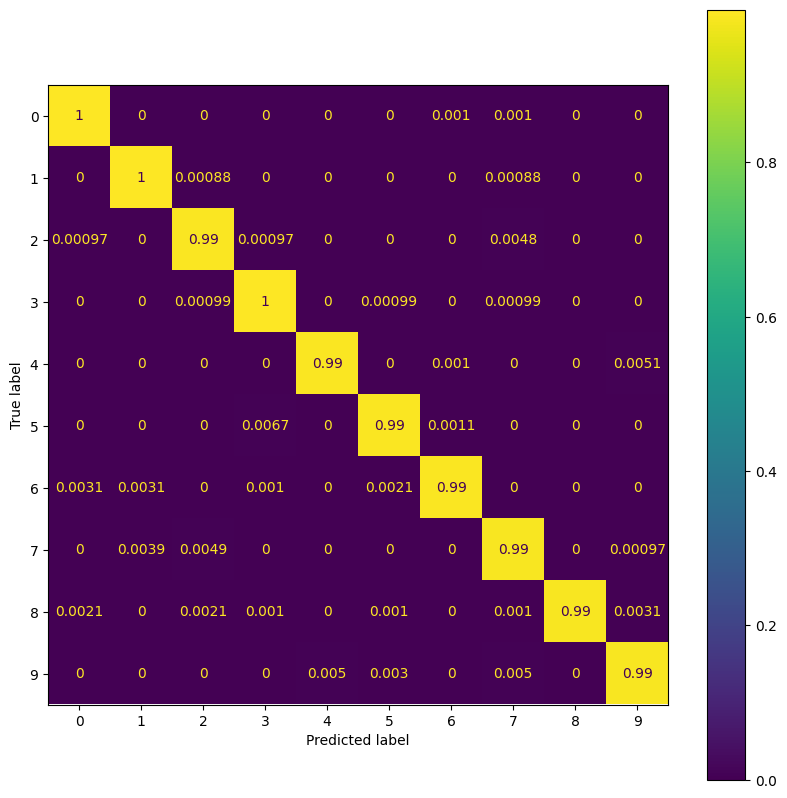

In [105]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_all, pred_y_all, normalize='true')
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax)

Text(0, 0.5, 'cvae 2')

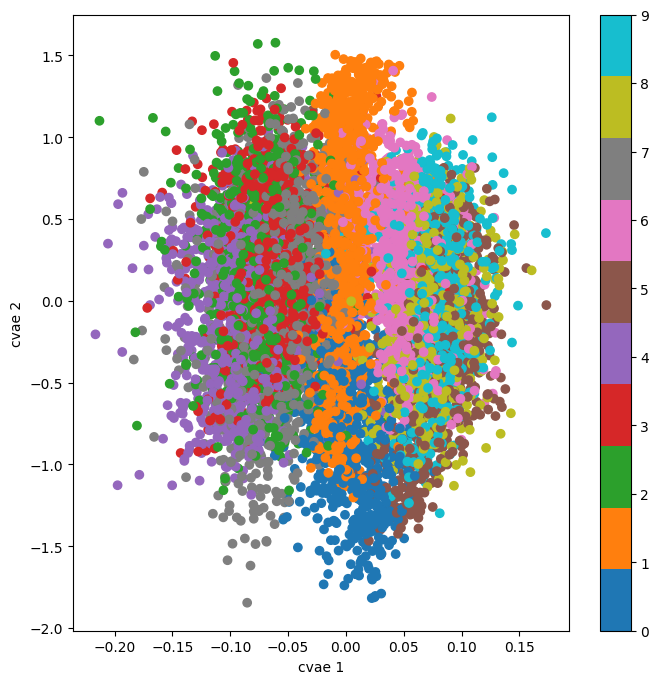

In [106]:
plt.figure(figsize=(8, 8))
plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10')
plt.colorbar()
plt.xlabel("cvae 1")
plt.ylabel("cvae 2")
# plt.show()
#plt.savefig('habr/mnist_2d_scatter_origin_labels_cvae.webp')

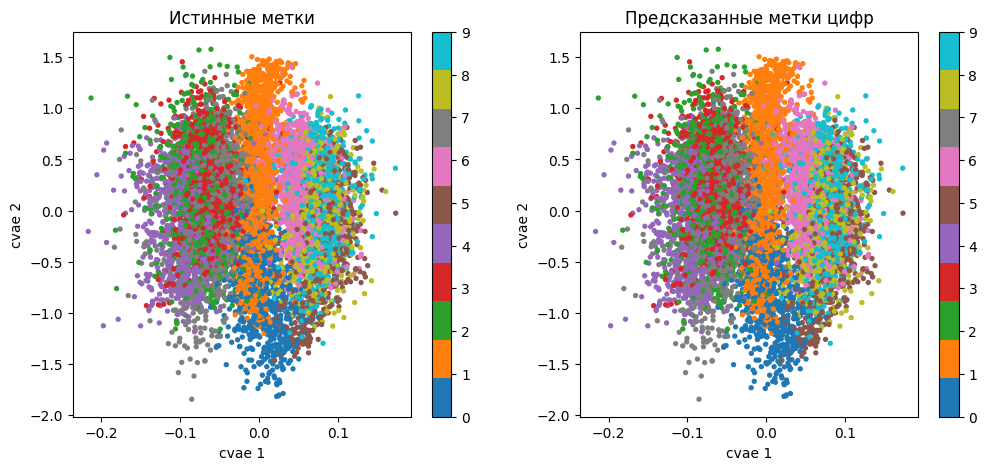

In [107]:
figure, axis = plt.subplots(1, 2, figsize=(12, 5)) 
sc1 =axis[0].scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10', s=8)
axis[0].set_title("Истинные метки")
axis[0].set_xlabel("cvae 1")
axis[0].set_ylabel("cvae 2")

sc2 = axis[1].scatter(z_all[:, 0], z_all[:, 1], c=pred_y_all, cmap='tab10', s=8)
axis[1].set_title("Предсказанные метки цифр") 
axis[1].set_xlabel("cvae 1")
axis[1].set_ylabel("cvae 2")
# sc3 = axis[2].scatter(z_all[:, 0], z_all[:, 1], c=pred_circ_all, cmap='spring')
# axis[2].set_title("Предсказанные метки очертаний") 
# axis[2].set_xlabel("cvae 1")
# axis[2].set_ylabel("cvae 2")
figure.colorbar(sc1)
figure.colorbar(sc2)
#figure.colorbar(sc3)
plt.show()

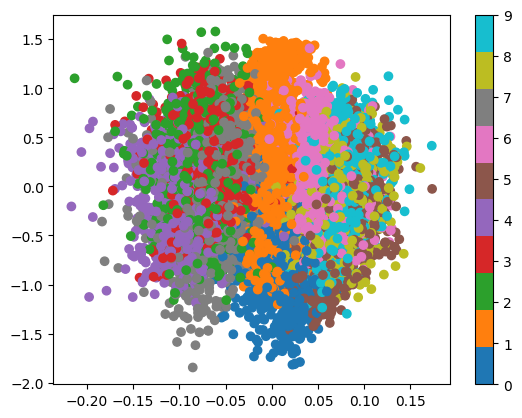

In [108]:

plt.scatter(z_all[:, 0], z_all[:, 1], c=pred_y_all, cmap='tab10')
plt.colorbar()
# plt.show()
plt.savefig('mnist_2d_scatter_fuzzy_pred_labels.webp')

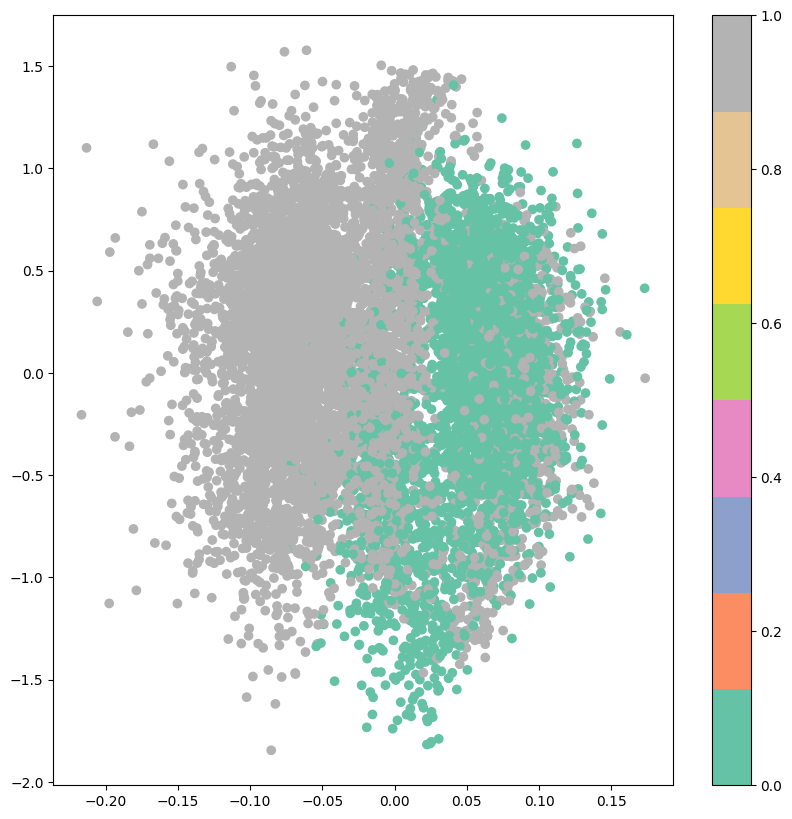

In [109]:
plt.figure(figsize=(10, 10))
plt.scatter(z_all[:, 0], z_all[:, 1], c=pred_circ_all, cmap='Set2')
plt.colorbar()
# plt.show()
plt.savefig('mnist_2d_scatter_fuzzy_pred_circles.webp')

In [110]:
n = 10
z2 = torch.linspace(-1, -0.5, n)
z1 = torch.zeros_like(z2) + 1

z = torch.stack([z1, z2], dim=-1).to(device)
samples = model.decoder_pass(z)
samples = torch.sigmoid(samples)

# Plot the generated images
fig, ax = plt.subplots(1, n, figsize=(n, 1))
for i in range(n):
    ax[i].imshow(samples[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
    ax[i].axis('off')
    
plt.savefig('cvae_mnist_interp.webp')

RuntimeError: mat1 dim 1 must match mat2 dim 0